# Data Analysis Interview Challenge

## Import

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

### Load and Wrangle Data 

In [3]:
# Read json file as panda DataFrame
login_df = pd.read_json('logins.json')

print(f'The first few rows of `logins.json` file: \n {login_df.head(10)} \n')
print(f'The descriptive statistic of this data: \n {login_df.describe()} \n')
print('The information about this DataFrame: \n')
login_df.info()

The first few rows of `logins.json` file: 
            login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
5 1970-01-01 20:21:41
6 1970-01-01 20:12:16
7 1970-01-01 20:35:47
8 1970-01-01 20:35:38
9 1970-01-01 20:47:52 

The descriptive statistic of this data: 
                  login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38 

The information about this DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


<ipython-input-3-76ba190988a9>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(f'The descriptive statistic of this data: \n {login_df.describe()} \n')


In [4]:
# Check the data types
print(f'The columns name: \n {login_df.columns} \n')
print(f'The data type: \n {login_df.dtypes} \n')
print(f'The value of `login_time` column in the first row: \n {login_df.login_time[0]} \n')
print(f'The data types of `login_time` column in the first row: \n {type(login_df.login_time[0])} \n')

The columns name: 
 Index(['login_time'], dtype='object') 

The data type: 
 login_time    datetime64[ns]
dtype: object 

The value of `login_time` column in the first row: 
 1970-01-01 20:13:18 

The data types of `login_time` column in the first row: 
 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 



In the DataFrame, the datetime value in login_time column is not ordered. This datetime columns is needed to sort in ascending order before using the aggregation function.

In [5]:
print("Total entries: ", len(login_df))
print("Earliest login in : ", min(login_df["login_time"]))
print("Latest time log in time: ", max(login_df["login_time"]))

Total entries:  93142
Earliest login in :  1970-01-01 20:12:16
Latest time log in time:  1970-04-13 18:57:38


In [6]:
# Missing value
login_df.isnull().sum()

# There is no missing value

login_time    0
dtype: int64

### Sorting the `login_time` value, and reset the index

In [7]:
# Sort datetime columns value and reset the row index
login_df = login_df.sort_values('login_time')
login_df = login_df.reset_index(drop=True)
login_df.head(10)

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37
5,1970-01-01 20:21:41
6,1970-01-01 20:26:05
7,1970-01-01 20:26:21
8,1970-01-01 20:31:03
9,1970-01-01 20:34:46


### Create a column name `login_count` for each time the user logs in

In [8]:
login_df['login_count'] = 1
print(f'Type of `login_df`: {type(login_df)}')
login_df.head()

Type of `login_df`: <class 'pandas.core.frame.DataFrame'>


,login_time,login_count
0,1970-01-01 20:12:16,1
1,1970-01-01 20:13:18,1
2,1970-01-01 20:16:10,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:16:37,1


### Aggregate these login counts based on 15 minute time intervals

In [9]:
login_series_15min = login_df.resample('15Min', on='login_time').login_count.sum()
print(f'Type of `login_series_15min`: {type(login_series_15min)}')

# Convert Series to DataFrame
login_df_15min = login_series_15min.to_frame()
print(f'Type of `login_df_15min` after converting: {type(login_df_15min)}')

print(f'Columns name of `login_df_15min`: {login_df_15min.columns}')

login_df_15min

Type of `login_series_15min`: <class 'pandas.core.series.Series'>
Type of `login_df_15min` after converting: <class 'pandas.core.frame.DataFrame'>
Columns name of `login_df_15min`: Index(['login_count'], dtype='object')


,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


### Visualize the time-series data and Find the trend

Text(111.25, 0.5, 'Number of Logins')

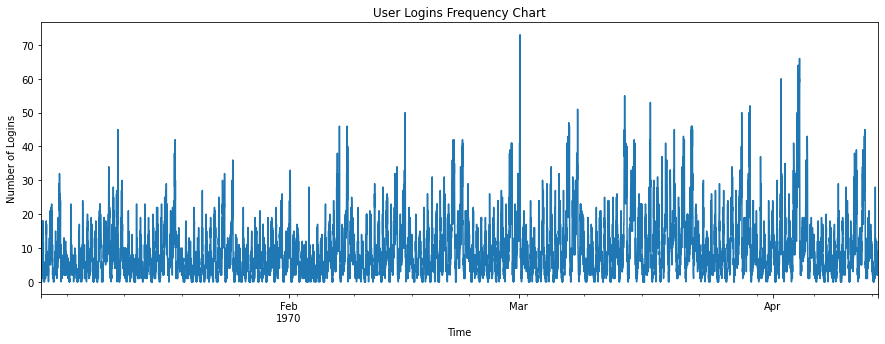

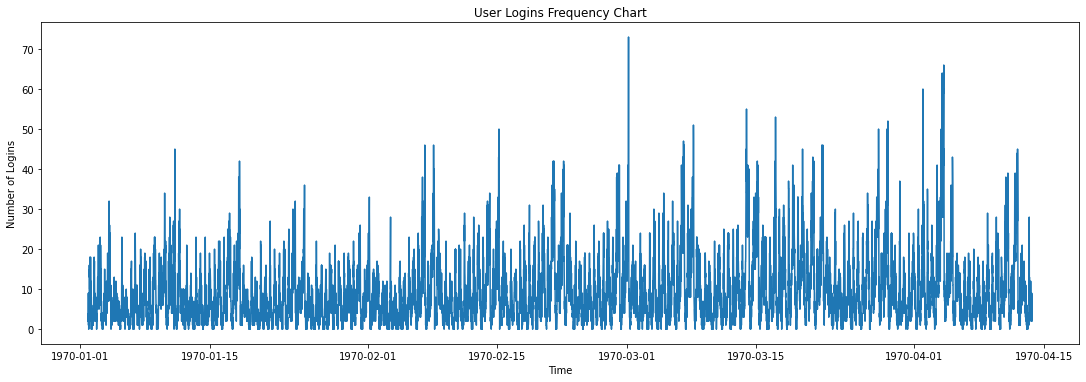

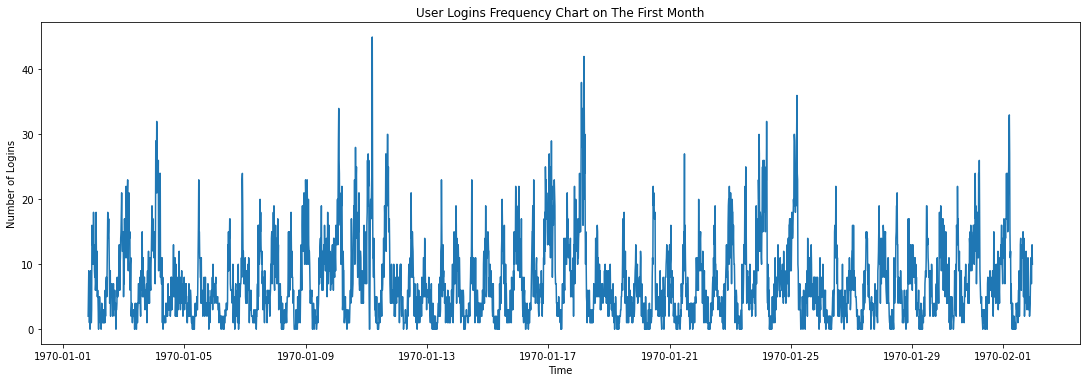

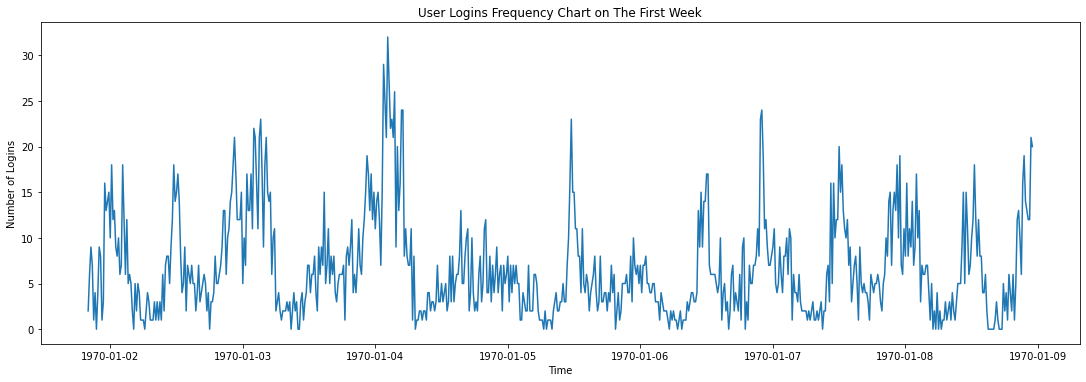

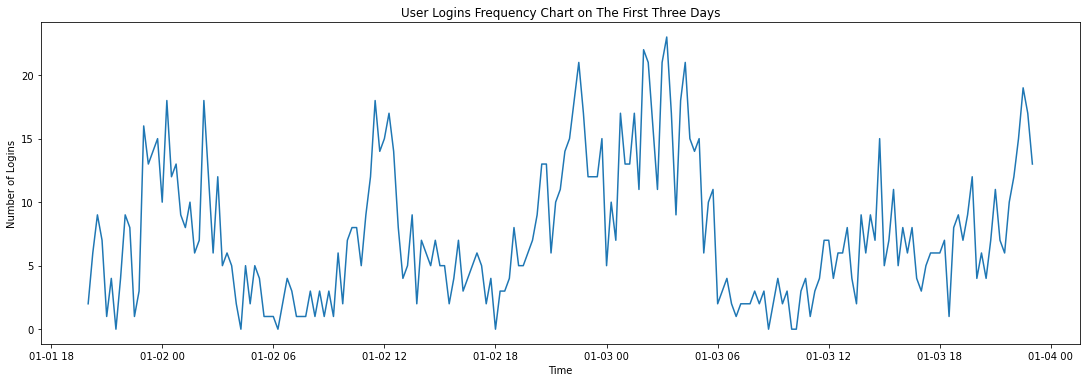

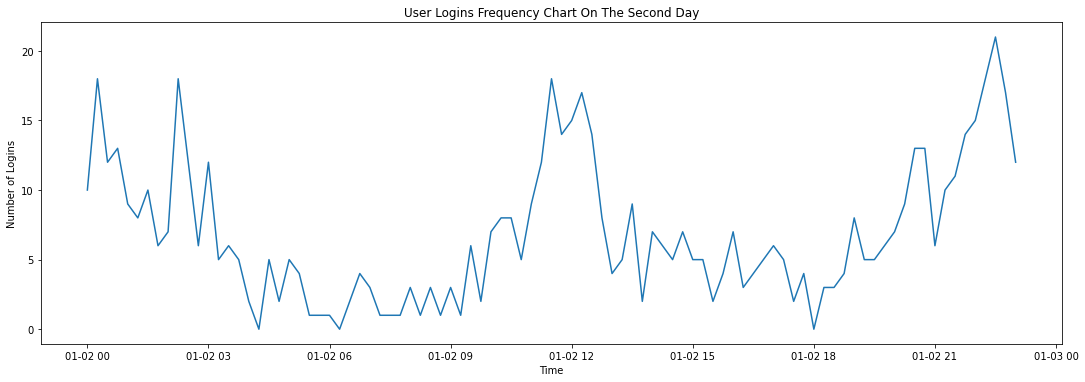

In [10]:
# --------------------Visualization using Series datatype-----------------------

plt.figure(figsize=(15,5)) 
login_series_15min.plot()

# Labeling the figure
plt.title('User Logins Frequency Chart')
plt.xlabel('Time')
plt.ylabel('Number of Logins')

# --------------------Visualization using dataframe datatype--------------------

# Create the scatterplot
plt.figure(figsize = (15,5))
plt.plot(login_df_15min.index, login_df_15min.login_count)
plt.tight_layout()

# Labeling the figure
plt.title('User Logins Frequency Chart')
plt.xlabel('Time')
plt.ylabel('Number of Logins')

##################Closer look of log in trend on the first month, week, month'##################

# -----------------On First month (DF)---------
login_df_1st_day = login_df_15min.loc['1970-01-01 00:00:00': '1970-02-01 23:00:00']

# Create the scatterplot
plt.figure(figsize = (15,5))
plt.plot(login_df_1st_day.index, login_df_1st_day.login_count)
plt.tight_layout()

# Labeling the figure
plt.title('User Logins Frequency Chart on The First Month')
plt.xlabel('Time')
plt.ylabel('Number of Logins')

# -----------------On First week (DF)---------
login_df_1st_day = login_df_15min.loc['1970-01-01 00:00:00': '1970-01-08 23:00:00']

# Create the scatterplot
plt.figure(figsize = (15,5))
plt.plot(login_df_1st_day.index, login_df_1st_day.login_count)
plt.tight_layout()

# Labeling the figure
plt.title('User Logins Frequency Chart on The First Week')
plt.xlabel('Time')
plt.ylabel('Number of Logins')

# -----------------On First three day (DF)---------
login_df_1st_day = login_df_15min.loc['1970-01-01 00:00:00': '1970-01-03 23:00:00']

# Create the scatterplot
plt.figure(figsize = (15,5))
plt.plot(login_df_1st_day.index, login_df_1st_day.login_count)
plt.tight_layout()

# Labeling the figure
plt.title('User Logins Frequency Chart on The First Three Days')
plt.xlabel('Time')
plt.ylabel('Number of Logins')

# -----------------On the second day (DF)---------
login_df_1st_day = login_df_15min.loc['1970-01-02 00:00:00': '1970-01-02 23:00:00']

# Create the scatterplot
plt.figure(figsize = (15,5))
plt.plot(login_df_1st_day.index, login_df_1st_day.login_count)
plt.tight_layout()

# Labeling the figure
plt.title('User Logins Frequency Chart On The Second Day')
plt.xlabel('Time')
plt.ylabel('Number of Logins')


Patterns & Conclusion


Based on the graphs, there are two patterns. The first trend is the log in activity reach its peak around every 12 hours, at late night/early morning (10pm to 3 am) and noon time each day (11am to noon). The second pattern is the log in activilities also peaking on the weekend.

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
    A. How you will implement the experiment
    
    B. What statistical test(s) you will conduct to verify the significance of the observation
    
    C. How you would interpret the results and provide recommendations to the city operations team along with any caveats.

1. Assuming the toll bridge has a system that can track vehicles via sticker transponders or licence plate, I would choose the customer toll bridge usage activities in both cities as the key metric. - Specifically, pre-reimbursement, and post-reimbursement for the driver partners crossing the toll bridge in both direction. The change in how often driving partners pass the bridge will show an increase/decrease in the number of drivers serving both cities, or there will be no difference. - When the trial shows a significant rise in the number of drivers crossing the bridge, it is deemed as a success that the reimbursing all toll costs encourage driver partners to be available in both cities. 

2. A. Track vehicles crossing the bridge via sticker transponders or licence plate, in both way 24/7 for a week pre-reimbursment, and reimbursment. During the reimbursment, the toll bridge system only scan their licence plate but not charge fee when they crossing, with sticker transponders or automatic box, the company refund within 24 hours after the system track the payment. B. I use one-sample z-test, where sample size >= 30 (driver partners), the alpha level α=0.05 (5%). Reject the null hypothesis when the p-value < α. - ho: There was no difference on driver bridge crossings whether the Ultimate company reimburses all toll costs or not. - h1: An increasing number of driver crossing the bridge when the Ultimate company reimburses all toll charges, than when pre-reimbursement is used. C. In case the experiement did not show the expected result in increasing the number of driver partners activities crossing the bridge to serve both cities, Ultimate company can extend this experiment from one month to three month to see clear observation.

## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Goal : Understand what factors are the best predictors for retention.


# 1. Data cleaning, exploratory analysis, and visualizations

In [12]:
# Loading and Cleaning the data

file_name = 'ultimate_data_challenge.json'
df = pd.read_json(file_name)

print(len(df))
df.head()


50000


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


The dataset has 12 columns and 50,000 records in total

In [13]:
# Display data frame information, columns name, and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Convert dates to datetime objects

In [14]:
# Check the datatype of `signup_date` and `last_trip_date`
print(f'Value type for `signup_date` column: {type(df.signup_date[0])}')
print(f'Value type for `last_trip_date` column: {type(df.last_trip_date[0])}')

# Convert dates to datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

print('\n----------- After Convert dates to datetime objects -----------')
print(f'Value type for `signup_date` column: {type(df.signup_date[0])}')
print(f'Value type for `last_trip_date` column: {type(df.last_trip_date[0])}')

Value type for `signup_date` column: <class 'str'>
Value type for `last_trip_date` column: <class 'str'>

----------- After Convert dates to datetime objects -----------
Value type for `signup_date` column: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Value type for `last_trip_date` column: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### A. Number Of Missing Values By Column

In [16]:
print("------------ Number Of Missing Values By Column ------------")
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

------------ Number Of Missing Values By Column ------------


,count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


There are missing values in columns: avg_rating_of_driver, phone, avg_rating_by_driver

In [17]:
# Check the rows has null values
rows_with_NaN = df[df.isnull().any(axis=1)]
rows_with_NaN

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


### B. Categorical Features

In [18]:
# Categorical features: 
cat_cols = list(df.select_dtypes([object, bool]).columns)

#numeric_col = list(df.select_dtypes(exclude=['object, bool']).columns)
print(f'There are {len(cat_cols)} features \n')
print(f'Categorical features are: \n{cat_cols}')

#### Unique value for object columns: `phone`, `ultimate_black_user`, `city`
print('--------Unique value for--------')
print(f'Phone: \n\t{df.phone.unique()}')
print(f'Ultimate Black User: \n\t{df.ultimate_black_user.unique()}')
print(f'City: \n\t{df.city.unique()}')

There are 3 features 

Categorical features are: 
['city', 'phone', 'ultimate_black_user']
--------Unique value for--------
Phone: 
	['iPhone' 'Android' None]
Ultimate Black User: 
	[ True False]
City: 
	["King's Landing" 'Astapor' 'Winterfell']


### C. Numerical Features

In [19]:
# Columns with numeric data type
numeric_col = list(df._get_numeric_data().columns)
print(f'There are {len(numeric_col)} Columns with numeric data type \n')
print(f'Columns with numeric data type are: \n{numeric_col}')

There are 8 Columns with numeric data type 

Columns with numeric data type are: 
['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']


In [20]:
# Statistical information of numeric columns
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### Replacing missing values



In [21]:
# Replace with columns mean for average rating, and 0 for empty phone number
df['phone'].fillna(str(0), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

print(df.phone.unique())
df.info()

['iPhone' 'Android' '0']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime6

### Convert categorical columns with numbers (phone, city, ultimate_black_user)

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


city_le = pd.DataFrame({'city': list(df.city.unique())})
phone_le = pd.DataFrame({'phone': list(df.phone.unique())})
ultimate_black_user_le = pd.DataFrame({'ultimate_black_user': list(df.ultimate_black_user.unique())})

city_le['city_encoded'] = le.fit_transform(city_le['city'].values)
phone_le['phone_encoded'] = le.fit_transform(phone_le['phone'].values)
ultimate_black_user_le['ultimate_black_user_encoded'] = le.fit_transform(ultimate_black_user_le['ultimate_black_user'].values)

city_le = city_le.drop_duplicates('city')
phone_le = phone_le.drop_duplicates('phone')
ultimate_black_user_le = ultimate_black_user_le.drop_duplicates('ultimate_black_user')

print(f'----- City -----: \n{city_le.to_string(index=False)}\n')
print(f'----- Phone -----: \n\t{phone_le.to_string(index=False)}\n')
print(f'----- Ultimate Black User -----: \n\t{ultimate_black_user_le.to_string(index=False)}\n')

# city
le.fit(df.city.drop_duplicates()) 
df.city = le.transform(df.city)

# phone
le.fit(df.phone.drop_duplicates()) 
df.phone = le.fit_transform(df.phone)

# ultimate_black_user
le.fit(df.ultimate_black_user.drop_duplicates()) 
df.ultimate_black_user = le.transform(df.ultimate_black_user)

df.info()

----- City -----: 
           city  city_encoded
 King's Landing             1
        Astapor             0
     Winterfell             2

----- Phone -----: 
	   phone  phone_encoded
  iPhone              2
 Android              1
       0              0

----- Ultimate Black User -----: 
	 ultimate_black_user  ultimate_black_user_encoded
                True                            1
               False                            0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date        

## Exploratory analysis

Questions to explore:

1. The preceding 30 days time period: end day and start day
1. Number of active and inactive users during that time (in preceding 30 days)

In [23]:
# The last day the dataset recorded with "preceding 30 days" time period
end_date = df.last_trip_date.max()
start_date = end_date - pd.Timedelta(days=30) 

print(f'The last day recorded in the dataset is: {end_date}')
print(f'The starting date in the preceding 30 days is: {start_date}')

# Add a active status column for the preceding 30 days, 1: Active; 0: Inactive
df['active'] = (df.last_trip_date > start_date).astype('int')

active = df[df['active'] == 1]
inactive = df[df['active'] == 0]

print(f'Number of active users: {len(active)}')
print(f'Number of in-active users: {len(inactive)}')

# Calculate the percentage of retained users
percent_retained_users = len(active) / len(df) * 100
print(f'The percentage of retained users: {round(percent_retained_users, 2)}%')

The last day recorded in the dataset is: 2014-07-01 00:00:00
The starting date in the preceding 30 days is: 2014-06-01 00:00:00
Number of active users: 18310
Number of in-active users: 31690
The percentage of retained users: 36.62%


In [24]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,1,4,2014-01-25,4.7,1.10,2014-06-17,2,15.4,1,46.2,3.67,5.0,1
1,0,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,0
2,0,3,2014-01-06,4.3,1.00,2014-01-07,2,0.0,0,100.0,0.77,5.0,0
3,1,9,2014-01-10,4.6,1.14,2014-06-29,2,20.0,1,80.0,2.36,4.9,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,0


## Visualization

The target column is 'active'.

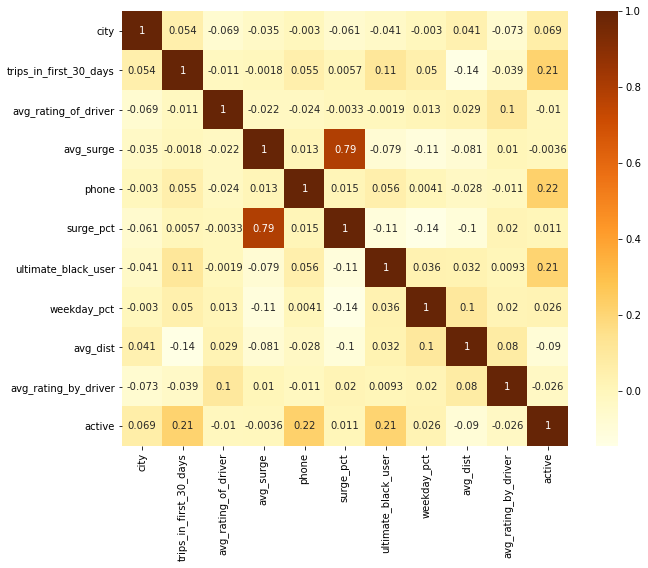

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='YlOrBr', annot=True);

Based on the correlation heatmap, it shows the top three features that are important to determine activer user in the preceding 30 days: trips_in_first_30_days, phone, ultimate_black_user.

/Users/soyoungan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/soyoungan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/soyoungan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

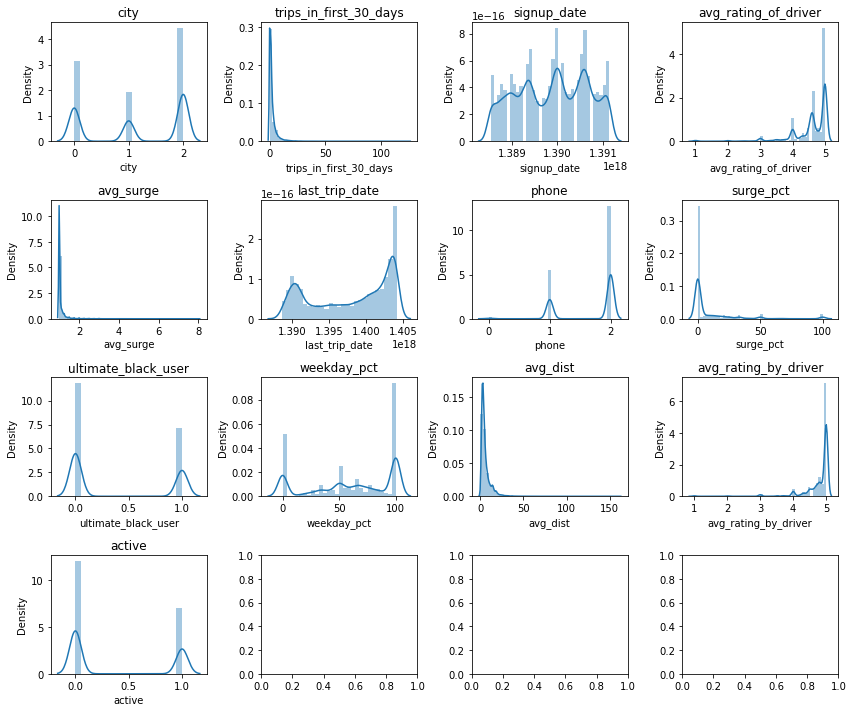

In [27]:
fig, axes = plt.subplots(nrows = 4, ncols = 4)    
axes = axes.flatten()         
fig.set_size_inches(12, 10)

for ax, col in zip(axes, list(df.columns)):
  sns.distplot(df[col], ax = ax)
  ax.set_title(col)
    
fig.tight_layout()

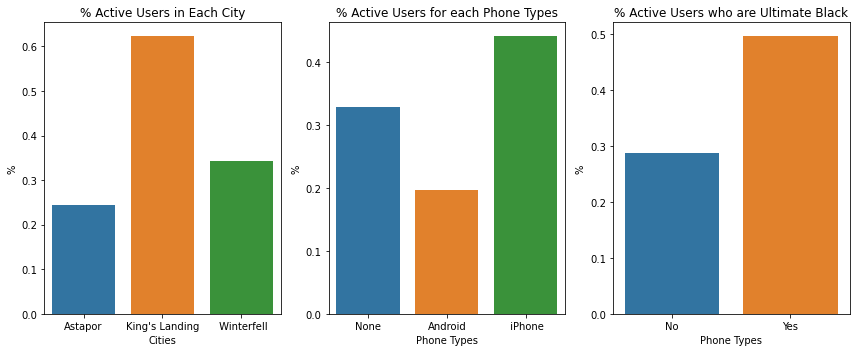

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

city_name = ['Astapor', "King's Landing", ' Winterfell']
city_0 = len(active[active['city'] == 0]) / len(df[df.city == 0])
city_1 = len(active[active['city'] == 1]) / len(df[df.city == 1])
city_2 = len(active[active['city'] == 2]) / len(df[df.city == 2])

phone_name = ['None', "Android", ' iPhone']
phone_0 = len(active[active['phone'] == 0]) / len(df[df.phone == 0])
phone_1 = len(active[active['phone'] == 1]) / len(df[df.phone == 1])
phone_2 = len(active[active['phone'] == 2]) / len(df[df.phone == 2])

ult_name = ['No', "Yes"]
ult_0 = len(active[active['ultimate_black_user'] == 0]) / len(df[df.ultimate_black_user == 0])
ult_1 = len(active[active['ultimate_black_user'] == 1]) / len(df[df.ultimate_black_user == 1])

       
# Plot and set labels 
ax1 = sns.barplot(x=city_name, y = [city_0, city_1, city_2], data=active, ax=ax1)
ax1.set(xlabel='Cities', ylabel='%', title='% Active Users in Each City')
          
ax2 = sns.barplot(x=phone_name, y = [phone_0, phone_1, phone_2], data=active, ax=ax2)
ax2.set(xlabel='Phone Types', ylabel='%', title='% Active Users for each Phone Types')

ax3 = sns.barplot(x=ult_name, y = [ult_0, ult_1], data=active, ax=ax3);
ax3.set(xlabel='Phone Types', ylabel='%', title='% Active Users who are Ultimate Black')

fig.tight_layout()

# 2. Predictive Models

In [29]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,1,4,2014-01-25,4.7,1.10,2014-06-17,2,15.4,1,46.2,3.67,5.0,1
1,0,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,0
2,0,3,2014-01-06,4.3,1.00,2014-01-07,2,0.0,0,100.0,0.77,5.0,0
3,1,9,2014-01-10,4.6,1.14,2014-06-29,2,20.0,1,80.0,2.36,4.9,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,0


In [30]:
# Create dummy variables for categorical features
df = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])

# All features need for training model
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_0,city_1,city_2,phone_0,phone_1,phone_2,ultimate_black_user_0,ultimate_black_user_1
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,0,1,0,1,0


In [31]:
df.isnull().sum()

trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
surge_pct                 0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active                    0
city_0                    0
city_1                    0
city_2                    0
phone_0                   0
phone_1                   0
phone_2                   0
ultimate_black_user_0     0
ultimate_black_user_1     0
dtype: int64

In [32]:
X = df.drop(columns=['last_trip_date','signup_date','active'], axis=1)  
y = df.active

In [33]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_0,city_1,city_2,phone_0,phone_1,phone_2,ultimate_black_user_0,ultimate_black_user_1
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0,1,0,1,0


In [34]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: active, dtype: int64

#### Train/Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Random Forest Classifier

Accuracy:  0.7594
Confusion matrix:  [[5178 1144]
 [1262 2416]]

avg_dist                  0.294135
weekday_pct               0.129037
avg_rating_by_driver      0.115512
avg_rating_of_driver      0.081153
trips_in_first_30_days    0.080404
surge_pct                 0.074856
avg_surge                 0.069801
city_1                    0.048677
phone_1                   0.021629
phone_2                   0.019759
ultimate_black_user_0     0.018105
city_0                    0.017599
ultimate_black_user_1     0.017166
city_2                    0.011049
phone_0                   0.001118
dtype: float64


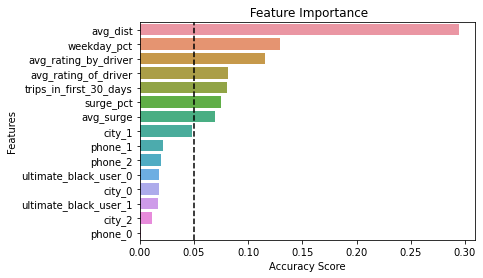

In [37]:
rf = RandomForestClassifier(n_estimators=100, random_state=27)

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))
print()

imp_features = pd.Series(rf.feature_importances_, index= X_train.columns).sort_values(ascending=False)
print(imp_features)

sns.barplot(x=imp_features, y=imp_features.index)
plt.xlabel('Accuracy Score')
plt.ylabel('Features')
plt.title(" Feature Importance")
plt.axvline(0.05, linestyle='dashed', color='black')

The top five essential factors that determined drivers' active status are: avg_dist, weekday_pct, avg_rating_by_driver, avg_rating_of_driver and trips_in_first_30_days

# 3. Discussion

Finally, I gain a lot of useful information from this dataset. I created a predictive model with 75.94 percent accuracy that will be beneficial for future forecasting. The model's insights are arguably more essential and profitable for the organization. The coefficients of Random Forest Classifier model have indicated important features among all drivers information. Using the five most important features, we can see the following effects on a rider's "activity" after 6 months.

Average distance: This is the most important features, as an increase in the average distance the driver traveled per trip in the first 30 days increases the chances of becoming an active user after 6 months.

Weekday percentage: The chance of becoming an active user increases as the percentage of weekday use increases. Therefore, we may conclude that encouraging customers to use the app on weekends.

Average rating by driver: The more time a driver spends evaluating his experiences, the more likely he is to utilize the app and stay engaged on the job.

Average rating of driver: There is a increase likelihood of being an active user as your rating goes up. More star ratings will encourage drivers to participate.

Trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Several recomendations for the company:

-Provide a promotion or bonus to drivers who complete a specified distance in their first 30 days.

-Provide incentives for riders to utilize the app during the week.

-Encourage drivers and customers to provide feedback on their experiences.

-Provide incentives for riders to take more trips within their first 30 days on the app.


Following these recommendation will improve the likelihood of more active users and, as a result, more income for the firm in the long run.